In [3]:
#CNN convolution 卷积神经网络
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True#代码提示

In [4]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [5]:
# 制作数据集
# 数据集转换参数
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(0.1307, 0.3081)
])
# 下载训练集与测试集
train_Data = datasets.MNIST(
root = '/Users/c1500' , # 下载路径
train = True, # 是train 集
download = True, # 如果该路径没有该数据集，就下载
transform = transform # 数据集转换参数
)
test_Data = datasets.MNIST(
root = '/Users/c1500' , # 下载路径
train = False, # 是test 集
download = True, # 如果该路径没有该数据集，就下载
transform = transform # 数据集转换参数
)

In [6]:
# 批次加载器
train_loader = DataLoader(train_Data, shuffle=True, batch_size=256)
test_loader = DataLoader(test_Data, shuffle=False, batch_size=256)
#train_Data: 这是一个 PyTorch 数据集对象,包含用于训练的数据。
#shuffle=True: 在每个 epoch 开始时,数据集会被随机打乱。这有助于减少训练过程中的偏差。
#batch_size=256: 每次训练时,模型会获取 256 个样本作为一个批次(batch)进行训练。批处理可以提高训练效率和收敛速度。

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),#C1卷积层 输入通道数为1 输出通道数为 6  卷积核 尺寸为 5x5 
                #stride  默认为 1 不写 激活函数是tanh
            nn.AvgPool2d(kernel_size=2, stride=2),#S2 平均汇聚层 尺寸是2x2 步幅是 2
            nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=5), nn.ReLU(),
            nn.Flatten(),#三维变为 1 维 将图像平铺成 1 维度
            nn.Linear(120, 84), nn.ReLU(),#全连接层 从 120 缩到 84
            nn.Linear(84, 10)
                )
    def forward(self, x):
        y = self.net(x)
        return y

In [8]:
#查看网络结构
X=torch.rand(size=(1,1,28,28))#输入数据
for layer in CNN().net:
    X=layer(X)
    print( layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Conv2d output shape:	 torch.Size([1, 120, 1, 1])
ReLU output shape:	 torch.Size([1, 120, 1, 1])
Flatten output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [9]:
#创建子类的实例，并且搬到 GPU 上
model=CNN().to('mps:0')
model

CNN(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [10]:
#损失函数的选择
loss_fn=nn.CrossEntropyLoss()#自带 softmax 激活函数



In [11]:
#优化算法的选择
learning_rate=0.9 #设置学习率
optimizer=torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
)

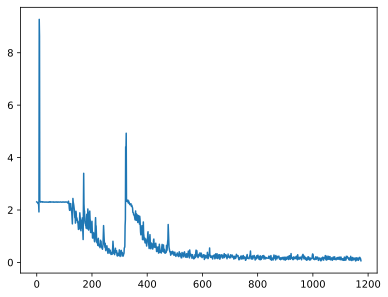

In [12]:
# 训练网络
epochs = 5
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('mps:0'), y.to('mps:0')
        Pred = model(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [13]:
# 测试网络
correct = 0
total = 0
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 x 与 y
        x, y = x.to('mps:0'), y.to('mps:0')
        Pred = model(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum( (predicted == y) )
        total += y.size(0)
        
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 95.87000274658203 %


In [14]:
#使用另一个数据集Fashion MNIST

import numpy as np
import pandas as pd
from torchvision.datasets import FashionMNIST
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])

train_data = FashionMNIST(
    root='/Users/c1500', # Download path
    train=True, # Is train set
    download=True, # Download if not available
    transform=transform # Data transformation
)
test_data = FashionMNIST(
    root='/Users/c1500', # Download path
    train=False, # Is test set
    download=True, # Download if not available
    transform=transform # Data transformation
)

In [15]:
#批次加载器
# 获取第一个 batch 的数据和标签


train_loader = DataLoader(train_data, shuffle=True, batch_size=64)
test_loader = DataLoader(test_data, shuffle=False, batch_size=64)
print(train_loader)
# 遍历数据
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Batch index: {batch_idx}")
    print(f"Input data shape: {data.shape}")
    print(f"Target shape: {target.shape}")
    # 您可以在这里查看 data 和 target 的内容
    if batch_idx == 0:
        break # 只打印第一个 batch 的数据


Batch index: 0
Input data shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])


In [16]:
model2=CNN().to('mps:0')
model2


CNN(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [17]:
#优化算法的选择
learning_rate=0.01 #设置学习率
optimizer=torch.optim.Adam(
    model2.parameters(),
    lr=learning_rate
)

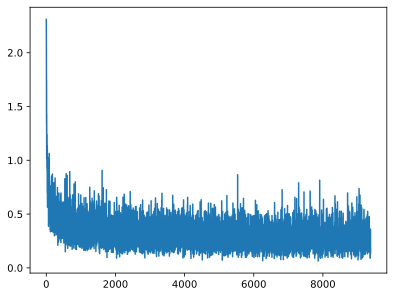

In [18]:
# 训练网络
epochs = 10
losses1 = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    for (x, y) in train_loader: # 获取小批次的 x 与 y
        x, y = x.to('mps:0'), y.to('mps:0')
        Pred = model2(x) # 一次前向传播（小批量）
        loss = loss_fn(Pred, y) # 计算损失函数
        losses1.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
Fig = plt.figure()
plt.plot(range(len(losses1)), losses1)
plt.show()

In [19]:
# 测试网络
correct = 0#精度-正确的样本数
total = 0#总样本数
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_loader: # 获取小批次的 输入数据 x 和标签 y
        x, y = x.to('mps:0'), y.to('mps:0')
        Pred = model2(x) # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)#将输出类别转换为标签(概率最大)-表示忽略最大值
        correct += torch.sum( (predicted == y) )
        total += y.size(0)
        
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 87.43000030517578 %
